## RED NEURONAL LSTM temporal - test ventanas temporales - versión 2

            ###############################
            ##  READMISIÓN HOSPITALARIA  ##
            ## Enfermedades de Digestivo ##
            ###############################

## Clasificacion con varias características - Datos Normalizados

### Ejemplo con dataset de Enfermedades de Digestivo - 30 días


El dataset se encuentra en un archivo tipo CSV: cmbd_digestivo_sinCab_RN_30dias.csv (/Users/shuli/User_shuli/datasets)

Se recrean los archivos normalizados con distintos timesteps (según parámetros desde...hasta):

#### Cambios en la versión 2

Se añade un particionamiento con estratificación debido al desbalanceamiento de los datasets. Se utiliza un 5-fold cross-validation lo que hace que se tenga un 20% de porcentaje de aciertos en el dataset de test y un 80% en el de entrenamiento


## Parámetros  -  configuración

In [1]:
ventana_tiempo_desde = 2
ventana_tiempo_hasta = 31

tipo_reingreso = 30

archivo_X_pre = '/Users/shuli/User_shuli/datasets/ReingresoDigestivo/Reing' + str(tipo_reingreso) + '/arrayReing' + str(tipo_reingreso) + '_Norm_X_'
archivo_y_pre = '/Users/shuli/User_shuli/datasets/ReingresoDigestivo/Reing' + str(tipo_reingreso) + '/arrayReing' + str(tipo_reingreso) + '_Norm_y_'

# Parámetros Red Neuronal

verbose = 0
epochs = 15
batch_size = 64
nodos1 = 100
nodos2 = 100
activation1 = 'relu'
activation2 = 'softmax'
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrics = 'accuracy'

num_folds = 5

## LSTM

Long Short-Term Memory. Son un tipo de redes neuronales recurrentes que pueden aprender y recordar largas secuencias de datos de entrada, en pasos hasta 200 a 400 pasos de tiempo.


### Librerías

Cargamos las librerías necesarias

In [2]:

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Particionado train/test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# lstm model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical

# Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.
/Users/shuli/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shuli/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shuli/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shuli/anaconda3/lib/python3.7/site-packages/tenso

### Funciones

**Función** para cargar el dataset _X_ a intervalos de timesteps (pasos temporales). Las 3 dimensiones del array son [samples, time steps, features] Devuelve el dataset transformado como parámetro de salida.

In [3]:
def load_X(dataset, timesteps):
    numcols = dataset.shape[1]
    numsteps = int(dataset.shape[0]/timesteps)

    a = dataset[0]

    for i in range(1, timesteps):
        num = dataset[i]
        a = np.append(a, num, axis=0)

    a = a.reshape(timesteps, numcols)

    b = dataset[timesteps]

    for i in range(timesteps+1, timesteps*2):
        num = dataset[i]
        b = np.append(b, num, axis=0)

    b = b.reshape(timesteps, numcols)

    x = np.append(a, b, axis=0)

    x = x.reshape(2, timesteps, numcols)

    for j in range(2, numsteps):
        b = dataset[timesteps*j]

        for i in range((timesteps*j)+1, timesteps*(j+1)):
            num = dataset[i]
            b = np.append(b, num, axis=0)

        b = b.reshape(timesteps, numcols)

        x = np.insert(x, x.shape[0], b, axis=0)
        
    print ('Creado dataset con estructura ', x.shape)

    return x

**Función** para cargar el dataset _y_ dando la salida correspondiente después de cada intervalo de timesteps (pasos temporales) dados como parámetro. Las dimensiones del array son [samples, features] Devuelve el dataset transformado como parámetro de salida.

In [4]:
def load_y(dataset, timesteps):
    numcols = dataset.shape[1]
    numsteps = int(dataset.shape[0]/timesteps)
    inicio = timesteps-1
    fin = dataset.shape[0]
    a = []
    
    for i in range(inicio, fin, timesteps):
        num = dataset[i]
        a = np.append(a, num)
    
    a = a.reshape(numsteps, numcols)
    
    print ('Creado dataset con estructura ', a.shape)
    
    return a

**Función** que cambia el dataset de salida de 2 dimensiones (one-hot encoding) a 1 dimensión tipo array. Se usa para comprobar el comportamiento de la Red Neuronal mediante las métricas de sklearn. La salida es un dataset de 1 dimensión tipo array.

In [5]:
def cambia_y_1dim (dataset):
    import numpy as np
    
    a = []
    for i in range(0, dataset.shape[0]):
        a = np.append(a, int(dataset[i][1]))
    
    b = a.astype(int)
    
    return b

**Función** que crea un modelo de red neuronal LSTM y la evalúa. Como entrada recibe los dataset de entrenamiento y prueba correspondientes. Como salida devuelve la exactitud en el test. También muestra:

    - Accuracy - (tp - tn) / (p + n)
    - Precision - tp / (tp + fp)
    - Recall - tp / (tp + fn)
    - f1 Score - 2 tp / (2 tp + fp + fn)
    - Kappa
    - ROC AUC
    - Confusion Matrix
    - Gráficos de entrenamiento y test para loss
    - Gráficos de entrenamiento y test para accuracy
    

In [6]:
def evaluate_model(trainX, trainy, testX, testy, verbose, epochs, batch_size, nodos1, nodos2, activation1, activation2, loss, optimizer, metrics):
    #verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(nodos1, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(nodos2, activation=activation1))
    model.add(Dense(n_outputs, activation=activation2))
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    # fit network
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # predict probabilities for test set
    yhat_probs = model.predict(testX, verbose=0)
    # predict crisp classes for test set
    yhat_classes = model.predict_classes(testX, verbose=0)
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    
    # No es necesario transformar, ya viene de 1 dimensión
    #yhat_classes = yhat_classes[:, 0]
    
    # Es necesario transformar testy ya que tiene 2 dimensiones (one-hot encoding)
    y_test = cambia_y_1dim (testy)
    
    print()
    print('RESULTADOS:')
    print('__________')
    print()

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy - (tp + tn) / (p + n): \t%f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision - tp / (tp + fp): \t\t%f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall - tp / (tp + fn): \t\t%f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score - 2 tp / (2 tp + fp + fn): \t%f' % f1)
    
    print()

    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    print('Cohens kappa: \t\t%f' % kappa)
    
    auc = 0
    # ROC AUC
    try:
        auc = roc_auc_score(y_test, yhat_probs)
    except:
        print('En este caso no se puede calcular ROC AUC - Error')

    print('ROC AUC: \t\t%f' % auc)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print()
    print('Matriz de Confusión: ')
    print()
    print(matrix)
    print()
    
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.2)
    pyplot.show()
    
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

### Cargamos y Preparamos el DataSet previo

Cargamos el dataset inicial sin ventana desde archivo

In [7]:
cols = ['HISTORIA_COD','FECNAC','SEXO','FECING','SERVING','SECCING','FECALT','SERVALT','SECCALT','TIPALT','FECINTERV','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','ED','Peso','GRDS','READMISION']
readDig = pd.read_csv(r'/Users/shuli/User_shuli/datasets/cmbd_digestivo_sinCab_RN_' + str(tipo_reingreso) + 'dias.csv', names=cols, header=None)

Como muchos de los datos que se disponen son categóricos, los convertiremos a numéricos, ya que Deep Learning está basado en algoritmos estadísticos que trabajan con campos numéricos.

El sistema más común para realizar esta labor es el algoritmo one-hot encoding. En este algoritmo, para cada valor único en cada columna categórica, se crea una nueva columna. Para las filas en la actual columna donde existía un único valor, se añade un 1 a la fila correspondiente de la columna creada para ese valor concreto.

El código que se muestra a continuación convierte las columnas categóricas en columnas numéricas.


In [8]:
SERVING = pd.get_dummies(readDig.SERVING, prefix='SERVING')
SECCING = pd.get_dummies(readDig.SECCING, prefix='SECCING')
SERVALT = pd.get_dummies(readDig.SERVALT, prefix='SERVALT')
SECCALT = pd.get_dummies(readDig.SECCALT, prefix='SECCALT')

D1 = pd.get_dummies(readDig.D1, prefix='D1')
D2 = pd.get_dummies(readDig.D2, prefix='D2')
D3 = pd.get_dummies(readDig.D3, prefix='D3')
D4 = pd.get_dummies(readDig.D4, prefix='D4')
D5 = pd.get_dummies(readDig.D5, prefix='D5')
D6 = pd.get_dummies(readDig.D6, prefix='D6')
D7 = pd.get_dummies(readDig.D7, prefix='D7')
D8 = pd.get_dummies(readDig.D8, prefix='D8')
D9 = pd.get_dummies(readDig.D9, prefix='D9')
D10 = pd.get_dummies(readDig.D10, prefix='D10')
D11 = pd.get_dummies(readDig.D11, prefix='D11')
D12 = pd.get_dummies(readDig.D12, prefix='D12')
D13 = pd.get_dummies(readDig.D13, prefix='D13')

P1 = pd.get_dummies(readDig.P1, prefix='P1')
P2 = pd.get_dummies(readDig.P2, prefix='P2')
P3 = pd.get_dummies(readDig.P3, prefix='P3')
P4 = pd.get_dummies(readDig.P4, prefix='P4')
P5 = pd.get_dummies(readDig.P5, prefix='P5')
P6 = pd.get_dummies(readDig.P6, prefix='P6')
P7 = pd.get_dummies(readDig.P7, prefix='P7')
P8 = pd.get_dummies(readDig.P8, prefix='P8')
P9 = pd.get_dummies(readDig.P9, prefix='P9')
P10 = pd.get_dummies(readDig.P10, prefix='P10')
P11 = pd.get_dummies(readDig.P11, prefix='P11')
P12 = pd.get_dummies(readDig.P12, prefix='P12')
P13 = pd.get_dummies(readDig.P13, prefix='P13')
P14 = pd.get_dummies(readDig.P14, prefix='P14')
P15 = pd.get_dummies(readDig.P15, prefix='P15')
P16 = pd.get_dummies(readDig.P16, prefix='P16')
P17 = pd.get_dummies(readDig.P17, prefix='P17')
P18 = pd.get_dummies(readDig.P18, prefix='P18')

Para crear nuestro conjunto de características, debemos preparar los datos y unir las 10 primeras columnas horizontalmente y, posteriormente, se unirán con el resto de columnas

In [9]:
previo1 = readDig[['HISTORIA_COD','FECNAC','SEXO','FECING','FECALT','TIPALT','FECINTERV','ED','Peso','GRDS']]
previo2 = pd.concat([SERVING,SECCING,SERVALT,SECCALT,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18], axis=1)

X = pd.concat([previo1,previo2], axis=1)

**Normalización**

Vamos a normalizar aquellas características que sean necesarias, utilizando valores entre 0 y 1.

La característica _SEXO_ no es necesario normalizar ya que solo toma los valores 1 ó 2.

Los valores que son necesario normalizar son: _HISTORIA_COD, FECNAC, FECING, FECALT, TIPALT, FECINTERV, ED, Peso y GRDS_.

In [10]:
# Función normalizadora
scaler = MinMaxScaler()

# Utilizamos otra variable
X3 = X

# Normalizamos y convertimos a DataFrame las primeras características
g1 = scaler.fit_transform(X3.iloc[:, :2])
g1d = pd.DataFrame(g1, columns = ['HISTORIA_COD','FECNAC'])

# Normalizamos y convertimos a DataFrame las características restantes
g2 = scaler.fit_transform(X3.iloc[:, 3:10])
g2d = pd.DataFrame(g2, columns = ['FECING','FECALT','TIPALT','FECINTERV','ED','Peso','GRDS'])

# Guardamos la característica que no se normaliza para después unificar
sexo = X3[['SEXO']]

# Unificamos todas las características (normalizadas y no normalizadas)
X4 = pd.concat([g1d,sexo,g2d], axis=1)
X5 = pd.concat([X4,previo2], axis=1)
X6 = X5.values

# Mostramos la forma del dataset a preparar
X6.shape


(14096, 21392)

Recogemos en la variable X_test nuestro dataset a utilizar en la red neuronal, con datos ya normalizados

In [11]:
X_test_orig = X6


Preparamos nuestro dataset de salida _y_


In [12]:
labels = pd.get_dummies(readDig.READMISION, prefix='READMITIDO')

y = labels.values


## BUCLE TIMESTEPS - Generación datos

Generamos métricas y gráficas para evaluar comportamiento de cada timestep del bucle, según configuración.

Se graba un archivo con cada dataset (X e y) de cada iteración (cada timestep) para usos posteriores en caso de necesidad.




*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 2 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (7048, 2, 21392)
Forma del dataset X:  (7048, 2, 21392)
Creado dataset con estructura  (7048, 2)
Forma del dataset y:  (7048, 2)



RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.845280
Precision - tp / (tp + fp): 		0.263158
Recall - tp / (tp + fn): 		0.109890
F1 score - 2 tp / (2 tp + fp + fn): 	0.155039

Cohens kappa: 		0.085441
ROC AUC: 		0.479426

Matriz de Confusión: 

[[1171   56]
 [ 162   20]]

Train: 1.000, Test: 0.845


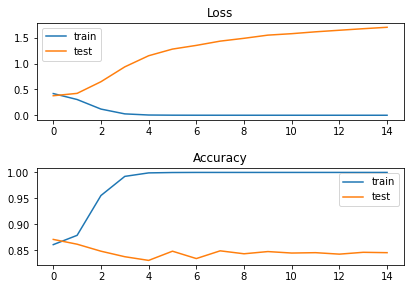


Accuracy (test) =  0.8452803492546082


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 2 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 3 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (4698, 3, 21392)
Forma del dataset X:  (4698, 3, 21392)
Creado dataset con estructura  (4698, 2)
Forma del dataset y:  (4698, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.840256
Precision - tp / (tp + fp): 		0.166667
Recall - tp / (tp + fn): 		0.067797
F1 score - 2 tp / (2 tp + fp + fn): 	0.096386

Cohens kappa: 		0.025570
ROC AUC: 		0.476357

Matriz de Confusión: 

[[781  40]
 [110   8]]

Train: 1.000, Test: 0.840


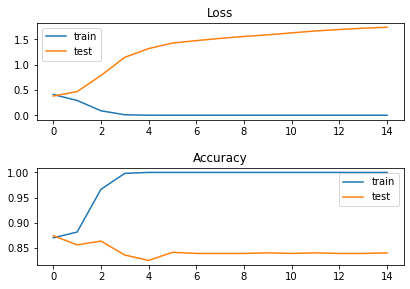


Accuracy (test) =  0.840255618095398


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 3 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 4 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (3524, 4, 21392)
Forma del dataset X:  (3524, 4, 21392)
Creado dataset con estructura  (3524, 2)
Forma del dataset y:  (3524, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.863636
Precision - tp / (tp + fp): 		0.333333
Recall - tp / (tp + fn): 		0.078652
F1 score - 2 tp / (2 tp + fp + fn): 	0.127273

Cohens kappa: 		0.083010
ROC AUC: 		0.451430

Matriz de Confusión: 

[[601  14]
 [ 82   7]]

Train: 1.000, Test: 0.864


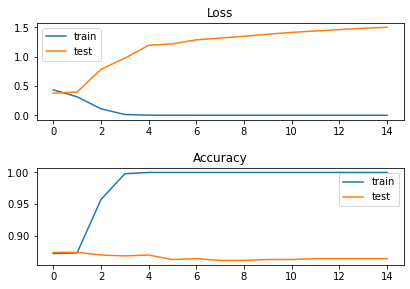


Accuracy (test) =  0.8636363744735718


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 4 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 5 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (2819, 5, 21392)
Forma del dataset X:  (2819, 5, 21392)
Creado dataset con estructura  (2819, 2)
Forma del dataset y:  (2819, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.845471
Precision - tp / (tp + fp): 		0.050000
Recall - tp / (tp + fn): 		0.014493
F1 score - 2 tp / (2 tp + fp + fn): 	0.022472

Cohens kappa: 		-0.034511
ROC AUC: 		0.527841

Matriz de Confusión: 

[[475  19]
 [ 68   1]]

Train: 1.000, Test: 0.845


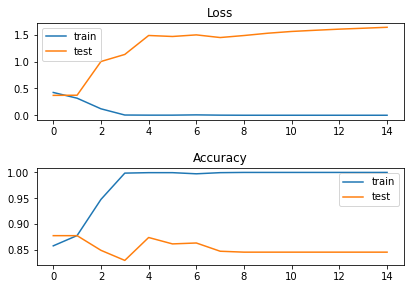


Accuracy (test) =  0.845470666885376


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 5 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 6 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (2349, 6, 21392)
Forma del dataset X:  (2349, 6, 21392)
Creado dataset con estructura  (2349, 2)
Forma del dataset y:  (2349, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.846482
Precision - tp / (tp + fp): 		0.058824
Recall - tp / (tp + fn): 		0.017544
F1 score - 2 tp / (2 tp + fp + fn): 	0.027027

Cohens kappa: 		-0.030518
ROC AUC: 		0.481115

Matriz de Confusión: 

[[396  16]
 [ 56   1]]

Train: 1.000, Test: 0.846


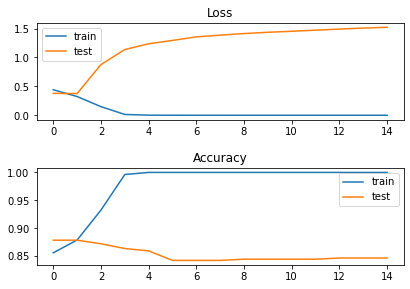


Accuracy (test) =  0.8464818596839905


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 6 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 7 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (2013, 7, 21392)
Forma del dataset X:  (2013, 7, 21392)
Creado dataset con estructura  (2013, 2)
Forma del dataset y:  (2013, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.875622
Precision - tp / (tp + fp): 		0.375000
Recall - tp / (tp + fn): 		0.062500
F1 score - 2 tp / (2 tp + fp + fn): 	0.107143

Cohens kappa: 		0.075607
ROC AUC: 		0.413400

Matriz de Confusión: 

[[349   5]
 [ 45   3]]

Train: 1.000, Test: 0.876


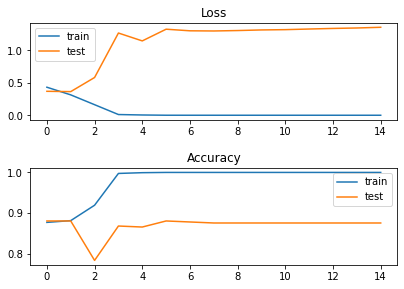


Accuracy (test) =  0.8756219148635864


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 7 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 8 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (1762, 8, 21392)
Forma del dataset X:  (1762, 8, 21392)
Creado dataset con estructura  (1762, 2)
Forma del dataset y:  (1762, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.863636
Precision - tp / (tp + fp): 		0.222222
Recall - tp / (tp + fn): 		0.046512
F1 score - 2 tp / (2 tp + fp + fn): 	0.076923

Cohens kappa: 		0.036167
ROC AUC: 		0.498495

Matriz de Confusión: 

[[302   7]
 [ 41   2]]

Train: 1.000, Test: 0.864


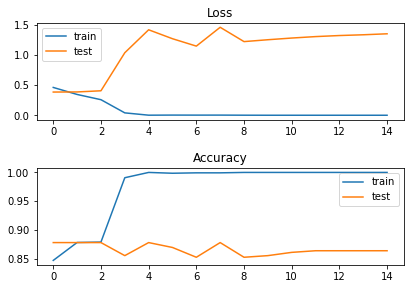


Accuracy (test) =  0.8636363744735718


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 8 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 9 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (1566, 9, 21392)
Forma del dataset X:  (1566, 9, 21392)
Creado dataset con estructura  (1566, 2)
Forma del dataset y:  (1566, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.843450
Precision - tp / (tp + fp): 		0.200000
Recall - tp / (tp + fn): 		0.046512
F1 score - 2 tp / (2 tp + fp + fn): 	0.075472

Cohens kappa: 		0.024922
ROC AUC: 		0.472093

Matriz de Confusión: 

[[262   8]
 [ 41   2]]

Train: 1.000, Test: 0.843


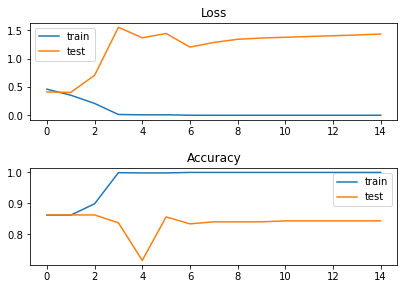


Accuracy (test) =  0.8434504866600037


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 9 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 10 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (1409, 10, 21392)
Forma del dataset X:  (1409, 10, 21392)
Creado dataset con estructura  (1409, 2)
Forma del dataset y:  (1409, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.871886
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		-0.013627
ROC AUC: 		0.516730

Matriz de Confusión: 

[[245   2]
 [ 34   0]]

Train: 1.000, Test: 0.872


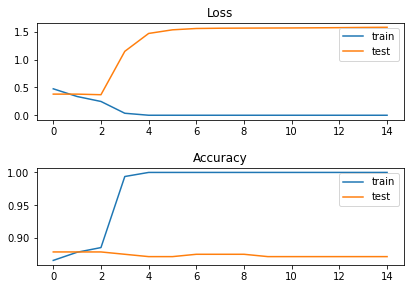


Accuracy (test) =  0.871886134147644


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 10 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 11 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (1281, 11, 21392)
Forma del dataset X:  (1281, 11, 21392)
Creado dataset con estructura  (1281, 2)
Forma del dataset y:  (1281, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.875000
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.411900

Matriz de Confusión: 

[[224   0]
 [ 32   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.875


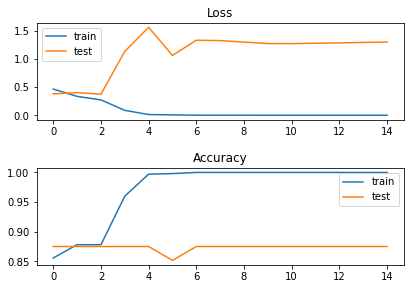


Accuracy (test) =  0.875


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 11 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 12 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (1174, 12, 21392)
Forma del dataset X:  (1174, 12, 21392)
Creado dataset con estructura  (1174, 2)
Forma del dataset y:  (1174, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.863248
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		-0.023790
ROC AUC: 		0.545332

Matriz de Confusión: 

[[202   3]
 [ 29   0]]

Train: 1.000, Test: 0.863


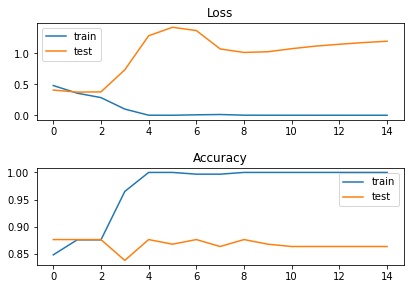


Accuracy (test) =  0.8632478713989258


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 12 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 13 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (1084, 13, 21392)
Forma del dataset X:  (1084, 13, 21392)
Creado dataset con estructura  (1084, 2)
Forma del dataset y:  (1084, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.842593
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		-0.025985
ROC AUC: 		0.523191

Matriz de Confusión: 

[[182   3]
 [ 31   0]]

Train: 1.000, Test: 0.843


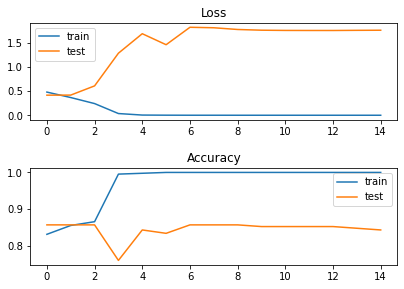


Accuracy (test) =  0.8425925970077515


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 13 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 14 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (1006, 14, 21392)
Forma del dataset X:  (1006, 14, 21392)
Creado dataset con estructura  (1006, 2)
Forma del dataset y:  (1006, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.885572
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.478627

Matriz de Confusión: 

[[178   0]
 [ 23   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.886


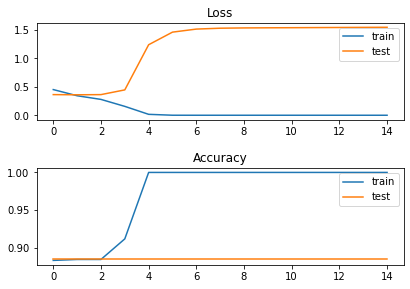


Accuracy (test) =  0.8855721354484558


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 14 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 15 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (939, 15, 21392)
Forma del dataset X:  (939, 15, 21392)
Creado dataset con estructura  (939, 2)
Forma del dataset y:  (939, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.877005
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.455992

Matriz de Confusión: 

[[164   0]
 [ 23   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.877


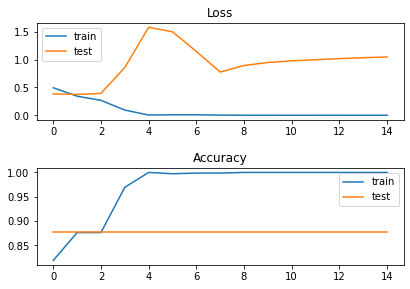


Accuracy (test) =  0.8770053386688232


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 15 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 16 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (881, 16, 21392)
Forma del dataset X:  (881, 16, 21392)
Creado dataset con estructura  (881, 2)
Forma del dataset y:  (881, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.875000
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.480815

Matriz de Confusión: 

[[154   0]
 [ 22   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.875


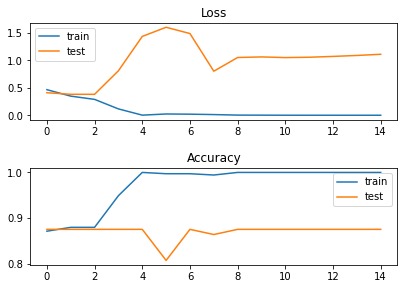


Accuracy (test) =  0.875


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 16 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 17 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (829, 17, 21392)
Forma del dataset X:  (829, 17, 21392)
Creado dataset con estructura  (829, 2)
Forma del dataset y:  (829, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.872727
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.456680

Matriz de Confusión: 

[[144   0]
 [ 21   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.873


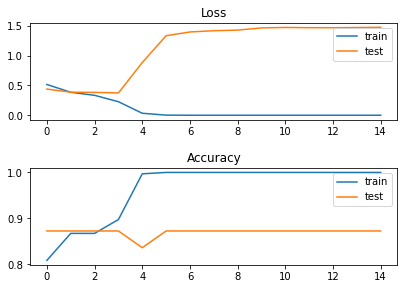


Accuracy (test) =  0.8727272748947144


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 17 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 18 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (783, 18, 21392)
Forma del dataset X:  (783, 18, 21392)
Creado dataset con estructura  (783, 2)
Forma del dataset y:  (783, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.865385
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.542681

Matriz de Confusión: 

[[135   0]
 [ 21   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.865


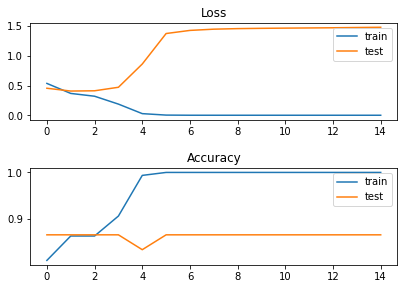


Accuracy (test) =  0.8653846383094788


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 18 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 19 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (741, 19, 21392)
Forma del dataset X:  (741, 19, 21392)
Creado dataset con estructura  (741, 2)
Forma del dataset y:  (741, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.871622
Precision - tp / (tp + fp): 		1.000000
Recall - tp / (tp + fn): 		0.050000
F1 score - 2 tp / (2 tp + fp + fn): 	0.095238

Cohens kappa: 		0.083442
ROC AUC: 		0.371680

Matriz de Confusión: 

[[128   0]
 [ 19   1]]

Train: 1.000, Test: 0.872


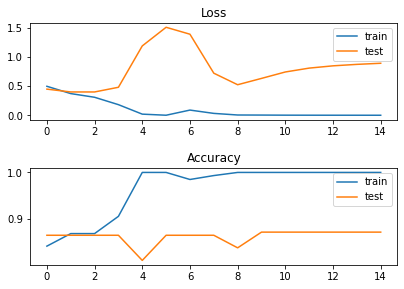


Accuracy (test) =  0.8716216087341309


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 19 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 20 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (704, 20, 21392)
Forma del dataset X:  (704, 20, 21392)
Creado dataset con estructura  (704, 2)
Forma del dataset y:  (704, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.885714
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.520413

Matriz de Confusión: 

[[124   0]
 [ 16   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.886


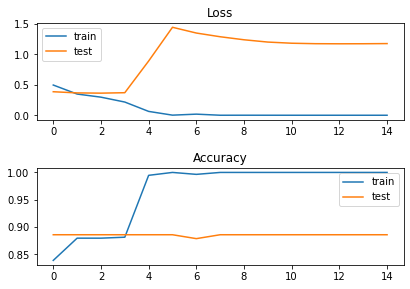


Accuracy (test) =  0.8857142925262451


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 20 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 21 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (671, 21, 21392)
Forma del dataset X:  (671, 21, 21392)
Creado dataset con estructura  (671, 2)
Forma del dataset y:  (671, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.880597
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.449682

Matriz de Confusión: 

[[118   0]
 [ 16   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.881


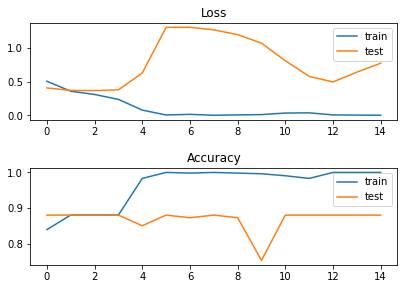


Accuracy (test) =  0.8805969953536987


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 21 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 22 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (640, 22, 21392)
Forma del dataset X:  (640, 22, 21392)
Creado dataset con estructura  (640, 2)
Forma del dataset y:  (640, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.875000
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.389509

Matriz de Confusión: 

[[112   0]
 [ 16   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.875


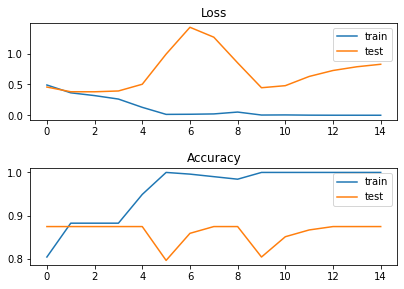


Accuracy (test) =  0.875


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 22 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 23 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (612, 23, 21392)
Forma del dataset X:  (612, 23, 21392)
Creado dataset con estructura  (612, 2)
Forma del dataset y:  (612, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.885246
Precision - tp / (tp + fp): 		0.500000
Recall - tp / (tp + fn): 		0.071429
F1 score - 2 tp / (2 tp + fp + fn): 	0.125000

Cohens kappa: 		0.099156
ROC AUC: 		0.509590

Matriz de Confusión: 

[[107   1]
 [ 13   1]]

Train: 1.000, Test: 0.885


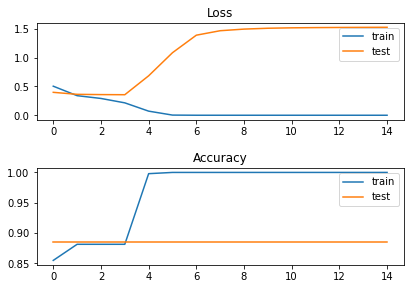


Accuracy (test) =  0.8852459192276001


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 23 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 24 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (587, 24, 21392)
Forma del dataset X:  (587, 24, 21392)
Creado dataset con estructura  (587, 2)
Forma del dataset y:  (587, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.888889
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.497781

Matriz de Confusión: 

[[104   0]
 [ 13   0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.889


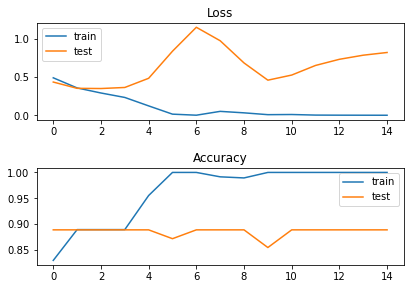


Accuracy (test) =  0.8888888955116272


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 24 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 25 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (563, 25, 21392)
Forma del dataset X:  (563, 25, 21392)
Creado dataset con estructura  (563, 2)
Forma del dataset y:  (563, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.875000
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.520044

Matriz de Confusión: 

[[98  0]
 [14  0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.875


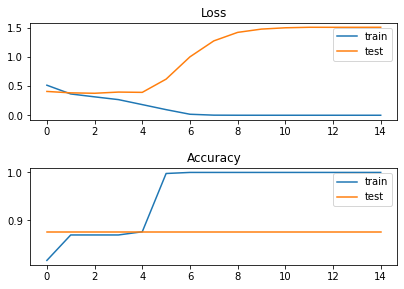


Accuracy (test) =  0.875


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 25 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 26 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (542, 26, 21392)
Forma del dataset X:  (542, 26, 21392)
Creado dataset con estructura  (542, 2)
Forma del dataset y:  (542, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.861111
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.602151

Matriz de Confusión: 

[[93  0]
 [15  0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.861


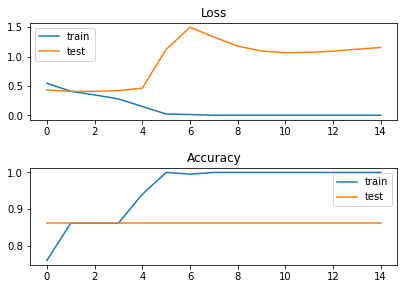


Accuracy (test) =  0.8611111044883728


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 26 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 27 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (522, 27, 21392)
Forma del dataset X:  (522, 27, 21392)
Creado dataset con estructura  (522, 2)
Forma del dataset y:  (522, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.855769
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.575281

Matriz de Confusión: 

[[89  0]
 [15  0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.856


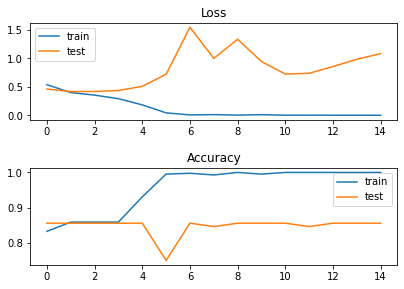


Accuracy (test) =  0.8557692170143127


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 27 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 28 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (503, 28, 21392)
Forma del dataset X:  (503, 28, 21392)
Creado dataset con estructura  (503, 2)
Forma del dataset y:  (503, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.890000
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.639428

Matriz de Confusión: 

[[89  0]
 [11  0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.890


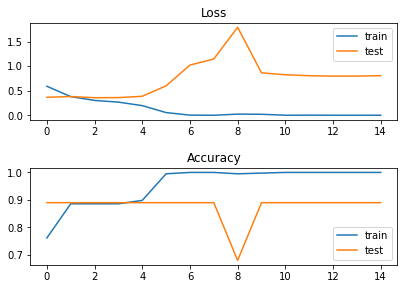


Accuracy (test) =  0.8899999856948853


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 28 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 29 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (486, 29, 21392)
Forma del dataset X:  (486, 29, 21392)
Creado dataset con estructura  (486, 2)
Forma del dataset y:  (486, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.865979
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.372711

Matriz de Confusión: 

[[84  0]
 [13  0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.866


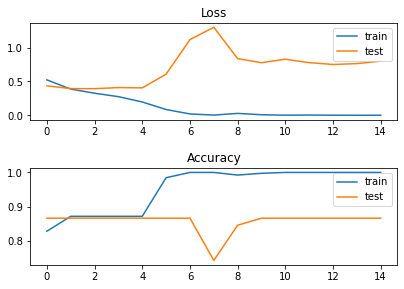


Accuracy (test) =  0.8659793734550476


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 29 TIMESTEPS
*********************************************************************



*********************************************************************
INICIO - REINGRESO 30 DÍAS CON 30 TIMESTEPS
*********************************************************************

Creado dataset con estructura  (469, 30, 21392)
Forma del dataset X:  (469, 30, 21392)
Creado dataset con estructura  (469, 2)
Forma del dataset y:  (469, 2)


RESULTADOS:
__________

Accuracy - (tp + tn) / (p + n): 	0.892473
Precision - tp / (tp + fp): 		0.000000
Recall - tp / (tp + fn): 		0.000000
F1 score - 2 tp / (2 tp + fp + fn): 	0.000000

Cohens kappa: 		0.000000
ROC AUC: 		0.556627

Matriz de Confusión: 

[[83  0]
 [10  0]]



/Users/shuli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train: 1.000, Test: 0.892


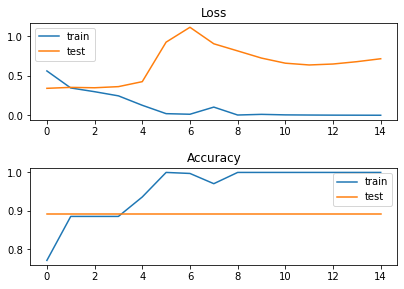


Accuracy (test) =  0.8924731016159058


*********************************************************************
FIN - REINGRESO 30 DÍAS CON 30 TIMESTEPS
*********************************************************************




In [13]:
for i in range(ventana_tiempo_desde, ventana_tiempo_hasta):

    archivo_X = archivo_X_pre + str(i) + 'timesteps_v2.npy'
    archivo_y = archivo_y_pre + str(i) + 'timesteps_v2.npy'
    
    print()
    print('*********************************************************************')
    print('INICIO - REINGRESO ' + str(tipo_reingreso) + ' DÍAS CON ' + str(i) + ' TIMESTEPS' )
    print('*********************************************************************')
    print()
    
    # Generamos array de i timesteps
    z = load_X(X_test_orig, i)
    
    # Guardamos a disco el array X
    np.save(archivo_X, z)
    
    # Mostramos la forma cargada
    print ('Forma del dataset X: ', z.shape)
    
    # Generamos array y
    y2 = load_y(y, i)
    
    # Guardamos a disco el array y
    np.save(archivo_y, y2)
    
    # Mostramos la forma cargada
    print ('Forma del dataset y: ', y2.shape)
    print()
    
    # Generamos los datasets de entrenamiento y test
    # X_train, X_test, y_train, y_test = train_test_split(z, y2, test_size=0.20, random_state=42)
    
    y3 = cambia_y_1dim(y2)

    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

    for train_index, test_index in skf.split(z, y3):
        X_train, X_test = z[train_index], z[test_index]
        y_train_pre, y_test_pre = y3[train_index], y3[test_index]

    # Se vuelve a dejar en formato 2 dimensiones
    y3_test = pd.get_dummies(y_test_pre)
    y3_train = pd.get_dummies(y_train_pre)

    y_test = y3_test.values
    y_train = y3_train.values
    
    # Lanzamos las pruebas
    acc = evaluate_model(X_train, y_train, X_test, y_test, verbose, epochs, batch_size, nodos1, nodos2, activation1, activation2, loss, optimizer, metrics)
    
    # Mostramos accuracy test
    print()
    print('Accuracy (test) = ', acc)
    print()
    
    print()
    print('*********************************************************************')
    print('FIN - REINGRESO ' + str(tipo_reingreso) + ' DÍAS CON ' + str(i) + ' TIMESTEPS' )
    print('*********************************************************************')
    print()
    print()